In [196]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [197]:
pattern = cv2.imread('data/trybik.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('data/trybiki2.jpg', cv2.IMREAD_GRAYSCALE)

In [198]:
def generalized_hough_transform_rotation_invariant(
        pattern: np.ndarray,
        image: np.ndarray,
        gradient_threshold: float = 0.5,
        rotation_step: int = 10, 
        visualise: bool = False
) -> np.ndarray:
    
    binarized = cv2.threshold(pattern, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    binarized = cv2.medianBlur(binarized, 5)
    contours, _ = cv2.findContours(cv2.bitwise_not(binarized), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    sobel_x = cv2.Sobel(pattern, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(pattern, cv2.CV_64F, 0, 1, ksize=5)

    gradient_direction_pattern = (np.rad2deg(np.arctan2(sobel_y, sobel_x)).astype(int)+180)%360

    momenta = cv2.moments(binarized, 1)
    x_mass_center = int(momenta['m10'] / momenta['m00'])
    y_mass_center = int(momenta['m01'] / momenta['m00'])

    Rtable = [[] for _ in range(360)]

    for point in contours[0]:
        x = point[0, 0] - x_mass_center
        y = point[0, 1] - y_mass_center
        Rtable[gradient_direction_pattern[point[0, 1], point[0, 0]]].append((np.sqrt(x*x + y*y), np.arctan2(y, x)))


    sobel_x_image = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y_image = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)

    gradient_magnitude_image = np.sqrt(sobel_x_image ** 2 + sobel_y_image ** 2)
    gradient_direction_image = (np.rad2deg(np.arctan2(sobel_y_image, sobel_x_image)).astype(int)+180)%360

    hough = np.zeros(image.shape + (36,), dtype=np.uint8)

    alphas = np.deg2rad(np.arange(0, 360, rotation_step))

    for y, x in zip(*np.where(gradient_magnitude_image > gradient_threshold*np.max(gradient_magnitude_image))):
        for r, phi in Rtable[gradient_direction_image[y, x]]:
            for c, alpha in enumerate(alphas):
                try:
                    hough[int(y - r*np.sin(phi+alpha)), int(x - r*np.cos(phi+alpha)), c] += 1
                except IndexError:
                    pass

    if visualise:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        for _ in range(4):
            idx = np.unravel_index(np.argmax(hough), hough.shape)
            y, x, df = idx[0], idx[1], alphas[idx[2]]
            for w in Rtable:
                for r, phi in w:
                    cv2.circle(
                        img=image,
                        center=(int(x - r*np.cos(phi + df)), int(y - r*np.sin(phi + df))),
                        radius=1,
                        color=(255, 0, 0)
                    )
            hough[idx[0]-70:idx[0]+70, idx[1]-70:idx[1]+70, :] = 0
        plt.imshow(image)
        plt.show()
    return hough

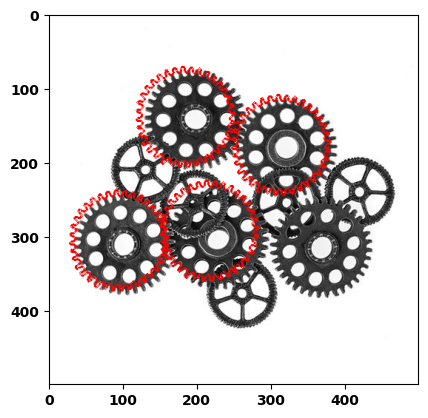

In [199]:
hough = generalized_hough_transform_rotation_invariant(pattern, image, visualise = True)
